In [1]:

import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import string
import re
import nltk
import sklearn
import matplotlib.pyplot as plt
import torch
import sys
import traceback
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from google_play_scraper import app, reviews,Sort
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Collecting

In [7]:
package = 'id.qoin.korlantas.user'

try:
    result = app(
        package,
        lang='id',  
        country='id'  
    )

    print("Nama Aplikasi:", result['title'])
    print("Deskripsi:", result['description'])
    print("Rating:", result['score'])
    print("Jumlah Review:", result['ratings'])
    print("Total Download:", result['installs'])
    print("Versi Terakhir:", result['version'])

except Exception as e:
    print("Terjadi kesalahan:", str(e))

Nama Aplikasi: Digital Korlantas POLRI
Deskripsi: Aplikasi Digital Korlantas POLRI adalah aplikasi resmi dari Korlantas POLRI Indonesia yang bertujuan untuk memberikan kemudahan kepada masyarakat Indonesia yang membutuhkan layanan Korlantas. Dalam aplikasi ini, masyarakat dapat menggunakan menu:
SINAR (SIM Nasional Presisi)
Perpanjangan SIM
Pembuatan SIM Baru (akan segera tersedia)
SIGNAL (Samsat Digital Nasional)
Pembayaran PKB (akan segera tersedia)
E-TBPKP dan E-Pengesahan (akan segera tersedia)
SAMSAT Keliling (akan segera tersedia)
NTMC POLRI
CCTV (akan segera tersedia)
Berita (akan segera tersedia)
ETLE (Electronic Traffic Law Enforcement)
Notifikasi Real Time (akan segera tersedia)
Kunjungi https://www.digitalkorlantas.id/ untuk informasi lebih lanjut.
Rating: 3.9609687
Jumlah Review: 125457
Total Download: 5.000.000+
Versi Terakhir: 1.6.5


In [8]:
data_review = []
continuation_token = None
for _ in range(4):

    result, continuation_token = reviews(
        package,
        lang = 'id',
        country = 'id',
        sort = Sort.NEWEST,
        count = 2500,
        continuation_token = continuation_token
    )
    data_review.extend(result)

df = pd.DataFrame(data_review)

df.to_csv('data_review.csv', index=False, encoding='utf-8')

for review in result:
    print("Review ID:", review['reviewId'])
    print("Username:", review['userName'])
    print("Skor:", review['score'])
    print("Tanggal:", review['at'])
    print("Komentar:", review['content'])
    print("---")
print("Continuation Token:", continuation_token)

Review ID: 39cfeffc-fa12-413a-8f56-870f970db448
Username: Pengguna Google
Skor: 1
Tanggal: 2024-04-28 11:02:30
Komentar: Aplikasi error, ada virus sepertinya
---
Review ID: 93ae7748-6edd-4a2b-9fa9-c0b6e7299a05
Username: Pengguna Google
Skor: 1
Tanggal: 2024-04-28 09:47:09
Komentar: Sangat mengecewakan, sudah melakukqn pembayaran sudah hampir 1 bulan stak di 40%, bukannya mempermudah malah mempersulit masyarakat. Mending tidak usah membuat inovasi kalau tidak bisa menjalankan dengan baik.
---
Review ID: ed63cd62-e966-4e22-bf25-fb82cd07aa5e
Username: Pengguna Google
Skor: 1
Tanggal: 2024-04-28 08:37:38
Komentar: Kok ada la aplikasi bobrok kek gini
---
Review ID: a9ff83f4-c977-4057-9455-2598ab13364f
Username: Pengguna Google
Skor: 1
Tanggal: 2024-04-27 20:44:47
Komentar: Nanda Febri
---
Review ID: a979c8ed-ef23-4cd6-a6a3-8dbf0c41a19b
Username: Pengguna Google
Skor: 1
Tanggal: 2024-04-27 19:59:43
Komentar: Nomor sim 13 digit gk bisa di input
---
Review ID: c89ae627-1c8f-41aa-9b04-60a7db84b

In [9]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,b01a7d50-d1c3-4c05-883e-01bd2dffb660,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat mudah untuk perpanjangan SIM C Terimah ...,5,0,1.6.5,2024-12-09 21:37:33,None,NaT,1.6.5
1,41372186-5710-4fdb-a013-59a74554681c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Perpanjang sim sedang dalam proses. Lama sekal...,1,0,1.6.5,2024-12-09 20:48:37,None,NaT,1.6.5
2,af746c51-838c-4810-826f-7ae6f46bb624,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap,5,0,1.6.3,2024-12-09 20:06:26,None,NaT,1.6.3
3,98330615-ed3c-4701-8ccb-ef0a2ac0e8d5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sangat lambat proses perpanjang sim, sampai ma...",1,0,1.6.5,2024-12-09 19:39:40,None,NaT,1.6.5
4,ddfb5ea8-9a35-47c8-94e6-e8458361a5fa,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat puas,5,0,1.6.5,2024-12-09 19:16:40,None,NaT,1.6.5


In [10]:
clean_df = df[['content','score']]

clean_df.head()

,content,score
0,Sangat mudah untuk perpanjangan SIM C Terimah ...,5
1,Perpanjang sim sedang dalam proses. Lama sekal...,1
2,mantap,5
3,"Sangat lambat proses perpanjang sim, sampai ma...",1
4,Sangat puas,5


In [11]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
 1   score    10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [12]:
clean_df.isna().sum()

content    0
score      0
dtype: int64

## Manual Labelling

In [ ]:
def map_sentiment(score):
    if score <= 3:
        return 'negatif'
    else:
        return 'positif'

clean_df['sentiment'] = clean_df['score'].apply(map_sentiment)
print(clean_df)


                                                content  score sentiment
0     Sangat mudah untuk perpanjangan SIM C Terimah ...      5   positif
1     Perpanjang sim sedang dalam proses. Lama sekal...      1   negatif
2                                                mantap      5   positif
3     Sangat lambat proses perpanjang sim, sampai ma...      1   negatif
4                                           Sangat puas      5   positif
...                                                 ...    ...       ...
9995                      Untuk perpanjang SIM kerennnn      5   positif
9996  Yang buat aplikasinya gapukkk, gagal terus ver...      1   negatif
9997  3 Hari dari persetujuan sim uda nyampe rumah. ...      5   positif
9998  Masih ada bug dalam mengungah foto, tapi masih...      4   positif
9999  Mantap luar biasa aplikasi nya, perpanjang leb...      5   positif

[10000 rows x 3 columns]


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_15012\1643186616.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['sentiment'] = clean_df['score'].apply(map_sentiment)


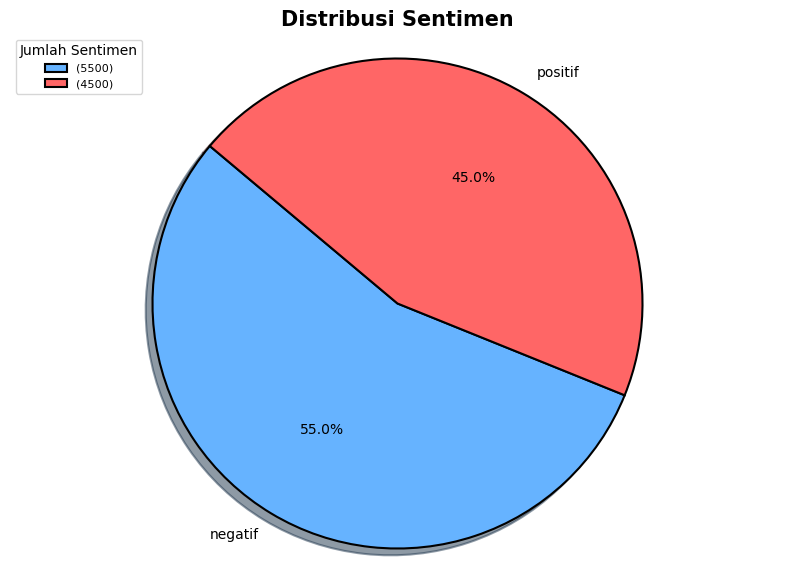

In [ ]:
sentiment_counts = clean_df['sentiment'].value_counts()

colors = ['#66b3ff', '#ff6666', '#99ff99'] 

plt.figure(figsize=(10, 7))
plt.pie(sentiment_counts, 
        labels=sentiment_counts.index, 
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=140, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': 'solid'}, 
        shadow=True)

plt.title('Distribusi Sentimen', fontsize=15, fontweight='bold')

legend_labels = [f"({count})" for count in sentiment_counts]

plt.legend(legend_labels, title="Jumlah Sentimen", loc="upper left", fontsize=8, frameon=True)


plt.axis('equal')  
plt.show()

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_15012\3699042125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['content'] = clean_df['content'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))


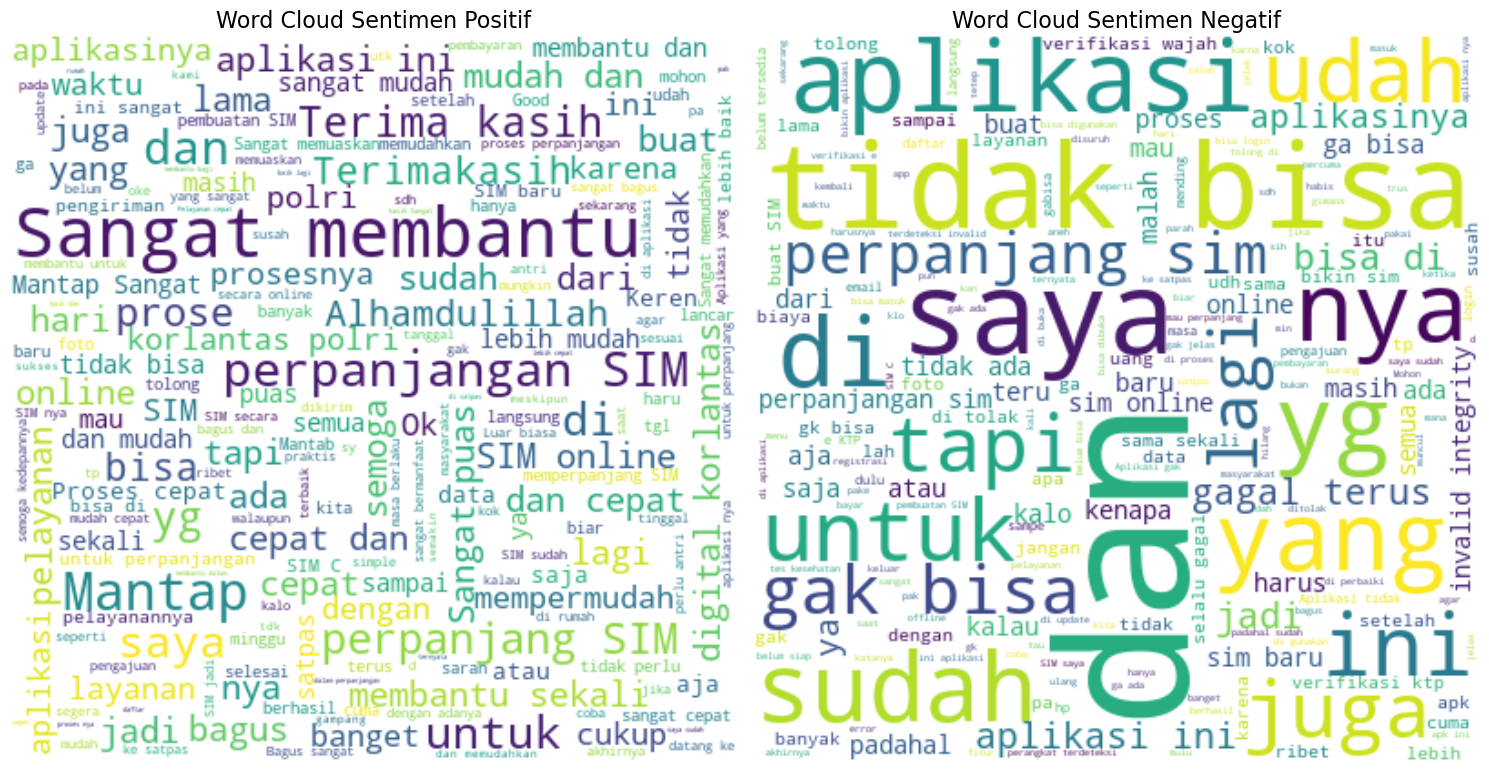

In [ ]:
clean_df['content'] = clean_df['content'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

positive_text = ' '.join(clean_df[clean_df['sentiment'] == 'positif']['content'])
negative_text = ' '.join(clean_df[clean_df['sentiment'] == 'negatif']['content'])

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud Sentimen Positif', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud Sentimen Negatif', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


## Pre proccessing

In [16]:
clean_df['content'] = clean_df['content'].astype('string')

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_15012\3725253240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['content'] = clean_df['content'].astype('string')


In [ ]:
clean_df= clean_df[['content', 'sentiment']]
clean_df = clean_df.copy()

In [ ]:
def case_folding(text):
    text = text.lower()
    return text

clean_df['content'] = clean_df['content'].apply(lambda x:case_folding(x))

clean_df.head()

,content,sentiment
0,sangat mudah untuk perpanjangan sim c terimah ...,positif
1,perpanjang sim sedang dalam proses. lama sekal...,negatif
2,mantap,positif
3,"sangat lambat proses perpanjang sim, sampai ma...",negatif
4,sangat puas,positif


In [20]:
def cleaning(text):
    text = re.sub(r"\d+", "", text) #menghilangkan angka
    text = text.translate(str.maketrans("","",string.punctuation)) #menghapus tanda baca
    text = text.strip() #menghapus karakter kosong
    return text
clean_df['content'] = clean_df['content'].apply(lambda x: cleaning(x))

clean_df.head()

,content,sentiment
0,sangat mudah untuk perpanjangan sim c terimah ...,positif
1,perpanjang sim sedang dalam proses lama sekali...,negatif
2,mantap,positif
3,sangat lambat proses perpanjang sim sampai mas...,negatif
4,sangat puas,positif


In [21]:
def emoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emotikon wajah
        "\U0001F300-\U0001F5FF"  # Simbol dan ikon
        "\U0001F680-\U0001F6FF"  # Transportasi dan simbol lainnya
        "\U0001F700-\U0001F77F"  # Simbol tambahan
        "\U0001F780-\U0001F7FF"  # Simbol tambahan lainnya
        "\U0001F800-\U0001F8FF"  # Simbol tambahan lainnya
        "\U0001F900-\U0001F9FF"  # Emotikon tambahan
        "\U0001FA00-\U0001FA6F"  # Simbol tambahan
        "\U0001FA70-\U0001FAFF"  # Simbol tambahan lainnya
        "\U00002702-\U000027B0"  # Simbol lainnya
        "\U000024C2-\U0001F251"
        "]+", 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

clean_df['content'] = clean_df['content'].apply(lambda x: emoji(x))

clean_df.head()


,content,sentiment
0,sangat mudah untuk perpanjangan sim c terimah ...,positif
1,perpanjang sim sedang dalam proses lama sekali...,negatif
2,mantap,positif
3,sangat lambat proses perpanjang sim sampai mas...,negatif
4,sangat puas,positif


In [22]:
clean_df['content'].astype('string')

0       sangat mudah untuk perpanjangan sim c terimah ...
1       perpanjang sim sedang dalam proses lama sekali...
2                                                  mantap
3       sangat lambat proses perpanjang sim sampai mas...
4                                             sangat puas
                              ...                        
9995                        untuk perpanjang sim kerennnn
9996    yang buat aplikasinya gapukkk gagal terus veri...
9997    hari dari persetujuan sim uda nyampe rumah pua...
9998    masih ada bug dalam mengungah foto tapi masih ...
9999    mantap luar biasa aplikasi nya perpanjang lebi...
Name: content, Length: 10000, dtype: string

## Perform Model

In [ ]:
def debug_tokenizer_loading(model_name):    
    print(f"Debugging tokenizer loading for model: {model_name}")
    print("\n--- Environment Check ---")
    print(f"Python Version: {sys.version}")
    print(f"Torch Version: {torch.__version__}")
    try:
        import transformers
        print(f"Transformers Version: {transformers.__version__}")
    except ImportError:
        print("Transformers library not found!")
    try:
        import sentencepiece
        print(f"SentencePiece Version: {sentencepiece.__version__}")
    except ImportError:
        print("SentencePiece library not found!")
    
    print("\n--- Tokenizer Loading Attempts ---")
    
    
    loading_attempts = [
        lambda: AutoTokenizer.from_pretrained(model_name),
        
        lambda: AutoTokenizer.from_pretrained(
            model_name, 
            use_fast=False, 
            trust_remote_code=True
        ),
        
        lambda: AutoTokenizer.from_pretrained(
            model_name, 
            use_fast=False, 
            local_files_only=True
        )
    ]
    
    for i, attempt in enumerate(loading_attempts, 1):
        print(f"\nAttempt {i}:")
        try:
            tokenizer = attempt()
            print("Sukses! Tokenizer berhasil dimuat.")
            return tokenizer
        except Exception as e:
            print(f"Gagal dengan error: {type(e).__name__}")
            print(f"Detail error: {str(e)}")
            print("Traceback:")
            traceback.print_exc()
    
    raise RuntimeError("Semua percobaan pemuatan tokenizer gagal!")

try:
    tokenizer = debug_tokenizer_loading("indobenchmark/indobert-base-p2")
except Exception as e:
    print(f"FATAL ERROR: {e}")
    tokenizer = None

if tokenizer is not None:
    model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2) 

    max_length = 64

    def tokenize_function(examples):
        contents = [str(content) if pd.notna(content) else '' for content in examples['content']]
        
        tokens = tokenizer(
            contents, 
            padding="max_length", 
            truncation=True, 
            max_length=max_length
        )
        
        tokens['labels'] = examples['sentiment']
        return tokens

    sentiment_map = {'positif': 1, 'negatif': 0}
    clean_df = clean_df[clean_df['sentiment'].isin(['positif', 'negatif'])]
    clean_df['sentiment'] = clean_df['sentiment'].map(sentiment_map)

    train_df, val_df = train_test_split(clean_df, test_size=0.2, stratify=clean_df['sentiment'])

    train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

    class_counts = clean_df['sentiment'].value_counts()
    total_samples = len(clean_df)
    class_weights = {i: total_samples / (len(class_counts) * class_counts[i]) for i in class_counts.index}
    weights = torch.tensor([class_weights[i] for i in range(2)], dtype=torch.float32)

    class LightweightTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.logits
          loss_fct = CrossEntropyLoss(weight=weights)
          loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
          return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="epoch",
        save_strategy="no",
        run_name='ultralight-indobert-sentiment',
        fp16=True,
        gradient_accumulation_steps=4,
        logging_steps=50,
        learning_rate=5e-5
    )

    trainer = LightweightTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()

    trainer.save_model('./ultralight_model')
    tokenizer.save_pretrained('./ultralight_model')
else:
    print("Tidak dapat melanjutkan proses pelatihan karena gagal memuat tokenizer.")

Debugging tokenizer loading for model: indobenchmark/indobert-base-p2

--- Environment Check ---
Python Version: 3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:41:22) [MSC v.1929 64 bit (AMD64)]
Torch Version: 2.5.1+cpu
Transformers Version: 4.47.0
SentencePiece Version: 0.2.0

--- Tokenizer Loading Attempts ---

Attempt 1:


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

d:\Programs\Anaconda3\envs\belajarML\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ThinkPad\.cache\huggingface\hub\models--indobenchmark--indobert-base-p2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Sukses! Tokenizer berhasil dimuat.


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

d:\Programs\Anaconda3\envs\belajarML\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.3944, 'grad_norm': 22.79747200012207, 'learning_rate': 2.5e-05, 'epoch': 0.2}
{'loss': 0.2127, 'grad_norm': 42.45787048339844, 'learning_rate': 5e-05, 'epoch': 0.4}
{'loss': 0.2419, 'grad_norm': 11.785675048828125, 'learning_rate': 4.375e-05, 'epoch': 0.6}
{'loss': 0.1644, 'grad_norm': 20.66966438293457, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.8}
{'loss': 0.1861, 'grad_norm': 5.121598720550537, 'learning_rate': 3.125e-05, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.20106640458106995, 'eval_runtime': 194.1862, 'eval_samples_per_second': 10.299, 'eval_steps_per_second': 1.287, 'epoch': 1.0}
{'loss': 0.1366, 'grad_norm': 6.788763999938965, 'learning_rate': 2.5e-05, 'epoch': 1.2}
{'loss': 0.1378, 'grad_norm': 14.382295608520508, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.4}
{'loss': 0.161, 'grad_norm': 14.521865844726562, 'learning_rate': 1.25e-05, 'epoch': 1.6}
{'loss': 0.1297, 'grad_norm': 2.4866578578948975, 'learning_rate': 6.25e-06, 'epoch': 1.8}
{'loss': 0.11, 'grad_norm': 27.102792739868164, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.20167209208011627, 'eval_runtime': 189.2239, 'eval_samples_per_second': 10.569, 'eval_steps_per_second': 1.321, 'epoch': 2.0}
{'train_runtime': 6255.0324, 'train_samples_per_second': 2.558, 'train_steps_per_second': 0.08, 'train_loss': 0.1874434871673584, 'epoch': 2.0}


## Evaluasi Model

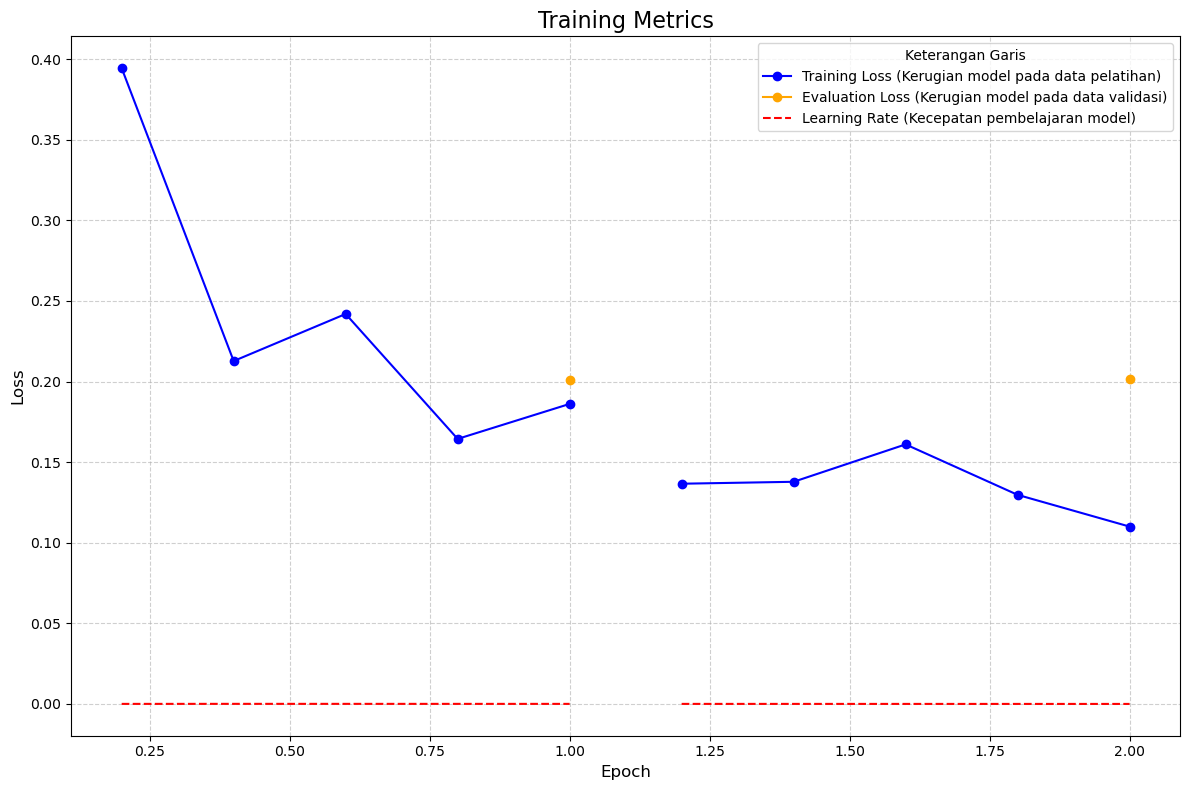

In [ ]:
def plot_training_metrics_with_full_legend(log_history):
    
    df = pd.DataFrame(log_history)

    df = df[df[['loss', 'eval_loss']].notnull().any(axis=1)]
    
    plt.figure(figsize=(12, 8))

    if 'loss' in df.columns:
        plt.plot(
            df['epoch'], 
            df['loss'], 
            label='Training Loss (Kerugian model pada data pelatihan)', 
            marker='o', 
            color='blue'
        )
    
    if 'eval_loss' in df.columns:
        plt.plot(
            df['epoch'], 
            df['eval_loss'], 
            label='Evaluation Loss (Kerugian model pada data validasi)', 
            marker='o', 
            color='orange'
        )
    
    if 'learning_rate' in df.columns:
        plt.plot(
            df['epoch'], 
            df['learning_rate'], 
            label='Learning Rate (Kecepatan pembelajaran model)', 
            linestyle='--', 
            color='red'
        )
    
    plt.title('Training Metrics', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.legend(
        loc='upper right',  
        fontsize=10,
        title="Keterangan Garis", 
        frameon=True
    )
    
    
    plt.tight_layout()
    plt.show()


plot_training_metrics_with_full_legend(trainer.state.log_history)


  0%|          | 0/250 [00:00<?, ?it/s]

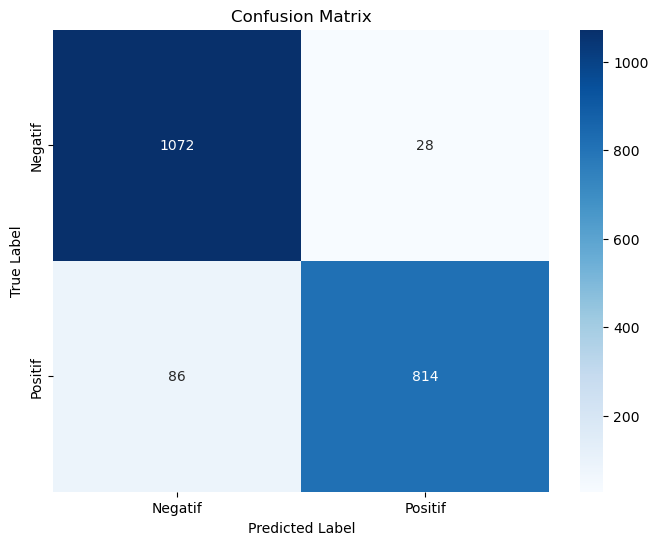

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

y_true = val_df['sentiment'].values

class_names = ['Negatif', 'Positif']

plot_confusion_matrix(y_true, y_pred, class_names)


In [ ]:


def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Negatif', 'Positif'])
    print(report)

print_classification_report(y_true, y_pred)


              precision    recall  f1-score   support

     Negatif       0.93      0.97      0.95      1100
     Positif       0.97      0.90      0.93       900

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



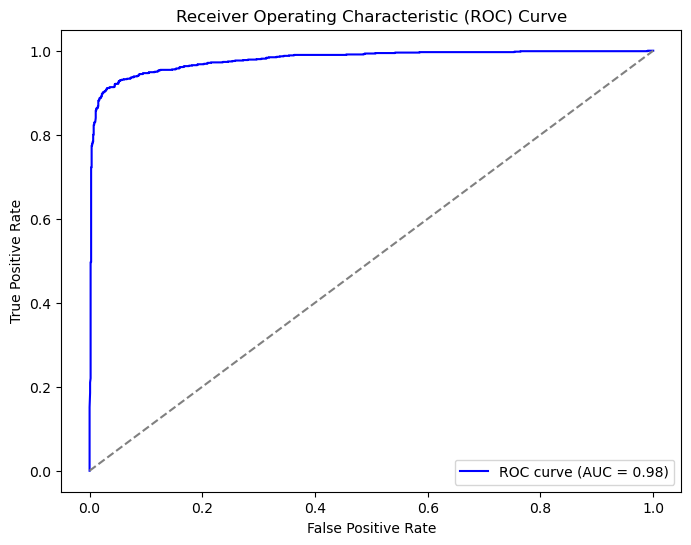

In [ ]:
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

y_pred_prob = predictions.predictions[:, 1]  

plot_roc_curve(y_true, y_pred_prob)


## Implementasi Model

In [ ]:
model_path = './ultralight_model'  
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

def predict_sentiment_multiple(texts):
    sentiments = []
    for text in texts:
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=64)
        
        model.eval()
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
        
        predicted_class = torch.argmax(logits, dim=1).item()

        sentiment = "Positif" if predicted_class == 1 else "Negatif"
        sentiments.append(sentiment)
    
    return sentiments
texts_input = [
    "Apaan aplikasi gajelas.",
    "Saya sangat puas dengan layanan ini!",
    "Produk ini buruk sekali, tidak berguna.",
    "Pelayanan yang luar biasa, sangat direkomendasikan."
]

sentiments = predict_sentiment_multiple(texts_input)

for text, sentiment in zip(texts_input, sentiments):
    print(f"Sentimen untuk teks: '{text}' adalah {sentiment}")


Sentimen untuk teks: 'Apaan aplikasi gajelas.' adalah Negatif
Sentimen untuk teks: 'Saya sangat puas dengan layanan ini!' adalah Positif
Sentimen untuk teks: 'Produk ini buruk sekali, tidak berguna.' adalah Negatif
Sentimen untuk teks: 'Pelayanan yang luar biasa, sangat direkomendasikan.' adalah Positif
